In [28]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
import yaml
import pickle
from itertools import product, cycle
import os, sys
from tqdm.notebook import tqdm
from scipy import stats
from scipy.stats import friedmanchisquare
import scikit_posthocs as s

from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))

*Analysis to perform*

1. Summary table of mean +- std of performances Dataset/Method/Metric
2. Analysis binned by total missing ratio;
3. Analysis binned by MNAR percentage; 

In [2]:
# load simulation results

simulation_path = "../../test_output/simulation_results17_12_2025.pkl"

with open(simulation_path, 'rb') as input_file:
    simulation_results = pickle.load(input_file)

In [3]:
# Load simulation configuration

with open("../../test_data/simulation_config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# conf is a tuple (dataset_id,props,mf_proportions,mnar_proportions, seed)

configs = list(product(
    cfg['dataset_ids'],
    cfg['md_param_grid']['props'],
    cfg['md_param_grid']['mf_proportions'],
    cfg['md_param_grid']['mnar_proportions'],
    range(cfg['n_runs'])
    ))

In [71]:
TESTED_METHODS = [
        'mige_no_proj',
        'mica',
        'kpod',
        'sc_knn',
        'sc_mi',
        'km_knn',
        'km_si'
    ]

In [4]:
# configs of dataset = dataset_id
# dataset_id = configs[0][0]
# key_subset = {k: v for k, v in d.items() if k[0] == X} this is for dictionaries
# conf_subset = [conf for conf in configs if conf[0] == dataset_id]

cfg['dataset_ids']

[33, 45, 17, 15, 174, 544]

In [6]:
def read_pickle(path):
    with open(path, 'rb') as input_file:
        return pickle.load(input_file)

## Missing ratios binning

In [7]:
# simulation results is a dictionary structured as such:
# simulation_results[conf][metric_type] metric_type in {external_metrics, internal_metrics}
# conf is a tuple (dataset_id,props,mf_proportions,mnar_proportions, seed)
# subset dictionary for first element subset = {k: v for k, v in d.items() if k[0] == X}

In [8]:
# tested external metrics 
external_metrics = list(simulation_results[configs[0]]['external_metrics']['mige_no_proj'])
# tested internal metrics 
internal_metrics = list(simulation_results[configs[0]]['internal_metrics']['mige_no_proj'])
# tested methods
methods = list(simulation_results[configs[0]]['internal_metrics'])

In [10]:
def safe_get(v, key1, key2):
    """
    This function is a safe get with double key because some are not list but single np.nan
    """
    try:
        return v[key1][key2]
    except:
        return np.nan

def spaghetti_dataframe_(df, metric_name):
    """
    This function is specific to pivot a dataframe into long format
    """
    df_long = (
        df.T
        .assign(metric=metric_name)
        .set_index("metric", append=True)
        .stack()
    )
    return df_long

In [16]:
def combine_dataset(results_df, metrics):
    """
    From aggregated result datasets with the form: 
    {metric: {dataset: {method: <value>}}}
    """
    long_dfs = {
    metric: spaghetti_dataframe_(
            df = pd.DataFrame.from_dict(results_df[metric]),
            metric_name = metric
        )
    for metric in metrics
    }
    combined = pd.DataFrame(pd.concat([df for df in long_dfs.values()]))
    combined.index = combined.index.set_names(['dataset','metric','method'])
    combined = combined.rename({0: "value"}, axis = 'columns') 
    combined = combined.unstack(level = -1)
    return combined

# External metrics aggregates

In [13]:
# build dictionaries to store:
# - results (lists for each of the 10 runs)
# - means and stds (single value)
# dictionary form {metric: {dataset: {method: <value>}}}

external_metrics_results = {met:{d:{m:[] for m in methods} for d in cfg['dataset_ids']} for met in external_metrics}
external_metrics_means = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in external_metrics}
external_metrics_stds = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in external_metrics}

for k1,v1 in simulation_results.items():
    dataset_id = k1[0]
    # collect results
    for metric in external_metrics:
        for method in methods:
            #res = v1['external_metrics'][method][metric]
            res = safe_get(v1['external_metrics'],method,metric)
            external_metrics_results[metric][dataset_id][method].append(res)

# calculate means and standard deviations
for metric,v1 in external_metrics_results.items():
    for dataset_id, v2 in v1.items():
        for method,v3 in v2.items():
            external_metrics_means[metric][dataset_id][method] = np.mean(v3)
            external_metrics_stds[metric][dataset_id][method] = np.std(v3)

In [23]:
combined_external_means = combine_dataset(external_metrics_means,external_metrics)
combined_external_stds = combine_dataset(external_metrics_stds,external_metrics)
combined_external_means.head(5)

value                                                 \
method         mige_no_proj mige_proj mige_leiden_no_proj mige_leiden_proj   
dataset metric                                                               
15      ami        0.763796  0.670903            0.265408         0.643626   
        ari        0.857685  0.732325            0.159362         0.672530   
        cs         0.763129  0.675302            0.288596         0.643583   
        vm         0.764064  0.671284            0.266426         0.644040   
17      ami        0.697122  0.677593            0.557955         0.627775   

                                                                            \
method              mica      kpod      mcnm      mghm    sc_knn     sc_mi   
dataset metric                                                               
15      ami     0.726800  0.483840       NaN  0.619954  0.586897  0.592504   
        ari     0.829540  0.531245       NaN  0.699463  0.673982  0.677042   
        cs      0.732503  0.537054       NaN  0.610515  0.616430  0.622873   
        vm      0.727112  0.484503       NaN  0.620378  0.587389  0.592989   
17      ami     0.457751  0.125200  0.511701  0.520766  0.498188  0.527622   

                                                            
method            km_knn     km_si cca_spectral cca_kmeans  
dataset metric                                              
15      ami     0.711794  0.728390     0.565245   0.747541  
        ari     0.816304  0.830840     0.633178   0.846468  
        cs      0.718935  0.734016     0.604710   0.752830  
        vm      0.712124  0.728700     0.565770   0.747829  
17      ami     0.455544  0.458708     0.536739   0.464005

## Ranks for external metrics

In [ ]:
# Calculate average rank for each method
combined_external_means['value'][TESTED_METHODS].rank(axis = 'columns', ascending = False).mean(axis=0)

method
mige_no_proj    1.708333
mica            4.250000
kpod            6.458333
sc_knn          3.750000
sc_mi           4.208333
km_knn          4.458333
km_si           3.166667
dtype: float64

# Internal metrics aggregates

In [20]:
internal_metrics_results = {met:{d:{m:[] for m in methods} for d in cfg['dataset_ids']} for met in internal_metrics}
internal_metrics_means = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in internal_metrics}
internal_metrics_stds = {met:{d:{m:np.nan for m in methods} for d in cfg['dataset_ids']} for met in internal_metrics}

for k1,v1 in simulation_results.items():
    dataset_id = k1[0]
    # collect results
    for metric in internal_metrics:
        for method in methods:
            #res = v1['internal_metrics'][method][metric]
            res = safe_get(v1['internal_metrics'],method,metric)
            internal_metrics_results[metric][dataset_id][method].append(res)

# calculate means and standard deviations

for metric,v1 in internal_metrics_results.items():
    for dataset_id, v2 in v1.items():
        for method,v3 in v2.items():
            internal_metrics_means[metric][dataset_id][method] = np.mean(v3)
            internal_metrics_stds[metric][dataset_id][method] = np.std(v3)

In [22]:
combined_internal_means = combine_dataset(internal_metrics_means, internal_metrics) 
combined_internal_stds = combine_dataset(internal_metrics_stds, internal_metrics)
combined_internal_means.head(5)

value                                                   \
method         mige_no_proj   mige_proj mige_leiden_no_proj mige_leiden_proj   
dataset metric                                                                 
15      ch       960.056839  858.707065          228.398192       752.037204   
        db         0.776924    0.839884            1.276433         0.895819   
        sh         0.635545    0.560748            0.037364         0.496927   
17      ch       718.624724  765.394780          751.755716       835.361836   
        db         0.689683    0.668916            1.035764         0.648692   

                                                                              \
method                 mica        kpod        mcnm        mghm       sc_knn   
dataset metric                                                                 
15      ch       978.721475  616.873124         NaN  668.709849   816.933131   
        db         0.771838    0.878015         NaN    0.917350     0.812214   
        sh         0.643339    0.582775         NaN    0.539803     0.625241   
17      ch      1286.222765  275.397839  902.651313  890.220372  1000.214556   
        db         0.505247    0.584524    0.602978    0.608042     0.569140   

                                                                                
method               sc_mi       km_knn        km_si cca_spectral   cca_kmeans  
dataset metric                                                                  
15      ch      824.009645   957.200347   978.799181   822.437456  1026.262388  
        db        0.808767     0.778323     0.771748     0.799292     0.757259  
        sh        0.627398     0.640223     0.643365     0.632756     0.651747  
17      ch      706.907172  1265.593009  1287.053596   738.656683  1300.208227  
        db        0.686116     0.509323     0.505357     0.671944     0.504404

## Ranks for internal metrics

In [92]:
# Calculate average rank for each method
LOWER_IS_BETTER = {"db"}

def rank_with_metric_direction(df):
    # this take second level index value at pos 0
    metric = df.index.get_level_values(1)[0] 
    return df.rank(
        axis="columns",
        ascending=metric in LOWER_IS_BETTER
    )

rank_mean = (
    combined_internal_means["value"][TESTED_METHODS]
    .groupby(level=1, group_keys=False)
    .apply(rank_with_metric_direction)
    .mean(axis=0)
)

rank_mean


method
mige_no_proj    4.333333
mica            2.777778
kpod            5.222222
sc_knn          4.611111
sc_mi           4.888889
km_knn          3.888889
km_si           2.277778
dtype: float64

## Dump data

In [24]:
# dump 
combined_external_means.to_csv("../../test_output/analysis/combined_external_means.csv")
combined_external_stds.to_csv("../../test_output/analysis/combined_external_stds.csv")
combined_internal_means.to_csv("../../test_output/analysis/combined_internal_means.csv")
combined_internal_stds.to_csv("../../test_output/analysis/combined_internal_stds.csv")

# Statistical tests

In [ ]:
def friedman_test(results, metrics):
    """
    """
    
    stat_res = {metric: None for metric in metrics}

    for metric in metrics:
        data = pd.DataFrame.from_dict(results[metric], orient='index')[TESTED_METHODS]
        stat, p = friedmanchisquare(*[data[col] for col in data.columns], nan_policy='omit')
        stat_res[metric] = p

    return stat_res

In [50]:
friedman_test(external_metrics_means, external_metrics)

{'ari': np.float64(0.032123631825024146),
 'ami': np.float64(0.008772316356192598),
 'vm': np.float64(0.008527150695431553),
 'cs': np.float64(0.013007392138685528)}

In [52]:
friedman_test(internal_metrics_means, internal_metrics)

{'sh': np.float64(0.0011407675925403996),
 'ch': np.float64(0.0001741744180321696),
 'db': np.float64(0.00017961033466218403)}

# Analysis stratified by missing ratios

In [92]:
missing_ratios = dict.fromkeys(set(configs))

for conf in tqdm(missing_ratios):
    dataset_id = conf[0]
    md_config = str(conf[1])+"_"+str(conf[2])+"_"+str(conf[3])
    seed = conf[4]
        
    """
    Load data for simulation
    """
    incomplete_data = read_pickle("../../test_data/missing_data/"+str(dataset_id)+"/"+md_config+"/data_pipeline_"+str(seed)+".pkl").amputer.incomplete_dataset
    missing_ratio = incomplete_data.isna().sum().sum()/(incomplete_data.shape[0] * incomplete_data.shape[1])
    missing_ratios[conf] = missing_ratio

  0%|          | 0/720 [00:00<?, ?it/s]

## Missing ratios frequencies

In [98]:
len(configs)

720

In [94]:
missing_stats = {k: [] for k in cfg['dataset_ids']}

for dataset_id in missing_stats.keys():
    key_subset = [k for k in missing_ratios.keys() if k[0] == dataset_id]
    for k in key_subset:
        missing_stats[dataset_id].append(missing_ratios[k])

C:\Users\simone\AppData\Local\Temp\ipykernel_34936\2952363892.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.boxplot(pd.DataFrame(missing_stats),


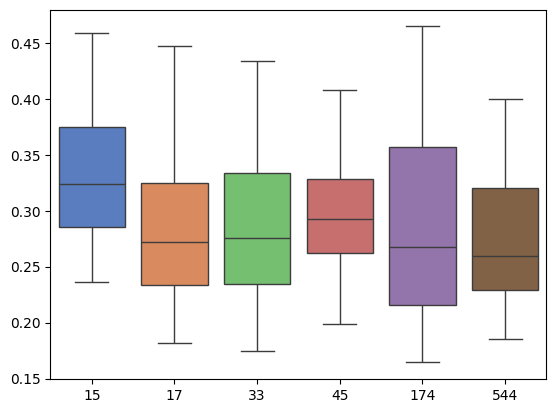

In [95]:
ax = sns.boxplot(pd.DataFrame(missing_stats),
                 palette = sns.color_palette("muted"))


## Missing ratio binning

In [99]:
# general binning
# bin in 5% 

bins = np.arange(0,1,.05)

# dataset binned key order:    dataset: -> metric -> method -> bins ->  list of res "in" bin 
external_metrics_binned = {
    dataset_id:{
        metric:{
            method:{
                bin:[] for bin in bins
                } for method in methods
            } for metric in external_metrics
        } for dataset_id in cfg['dataset_ids']
}

In [100]:
for cfg, v1 in simulation_results.items():

    dataset_id = cfg[0]
    bin = bins[np.digitize(missing_ratios[cfg], bins, right=True)]

    for method, v2 in v1['external_metrics'].items():
        try:
            for metric, v3 in v2.items():
                external_metrics_binned[dataset_id][metric][method][bin].append(v3)
        except:
            for metric in external_metrics:                 
                external_metrics_binned[dataset_id][metric][method][bin].append(np.nan)
            


In [101]:
markers = cycle(['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h'])
linestyles = cycle(['-.',':'])
colors = cycle(sns.color_palette("tab10"))

style = {m:{} for m in methods}
for method in methods:
    style[method]['marker'] = next(markers)
    style[method]['color'] = next(colors)
    if 'mige' in method:
        style[method]['linestyle'] = '-'
    elif 'cca' in method:
        style[method]['linestyle'] = '--'
    else:
        style[method]['linestyle'] = next(linestyles)

In [103]:
data

{'mige_no_proj': {np.float64(0.0): [],
  np.float64(0.05): [],
  np.float64(0.1): [],
  np.float64(0.15000000000000002): [],
  np.float64(0.2): [],
  np.float64(0.25): [0.8797999594058095,
   0.8741717376080064,
   0.8796529340278119,
   0.890950657307329,
   0.9078184290265888,
   0.868671455441548,
   0.868671455441548,
   0.879690832980047,
   0.8909190251664287,
   0.9134143670155777,
   0.8631481365705013,
   0.868671455441548,
   0.8908867046187453,
   0.8909190251664287,
   0.8964892456950633],
  np.float64(0.30000000000000004): [0.8742101851883491,
   0.8629721881148718,
   0.8465709688648306,
   0.8798348159390051,
   0.8415410296345396,
   0.8797643442937378,
   0.8630174812177713,
   0.8465197572405806,
   0.8799022584447733,
   0.8578903863772493,
   0.8797643442937378,
   0.8575496157294773,
   0.8575029605818916,
   0.8798689151946667,
   0.8524507500592382,
   0.8798689151946667,
   0.9021905747454844,
   0.8854004453704861,
   0.896578305601169,
   0.8909190251664287,
 

c:\Users\simone\anaconda3\envs\miclust\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\simone\anaconda3\envs\miclust\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\simone\AppData\Local\Temp\ipykernel_34936\346323917.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values)  # Standard error of the mean


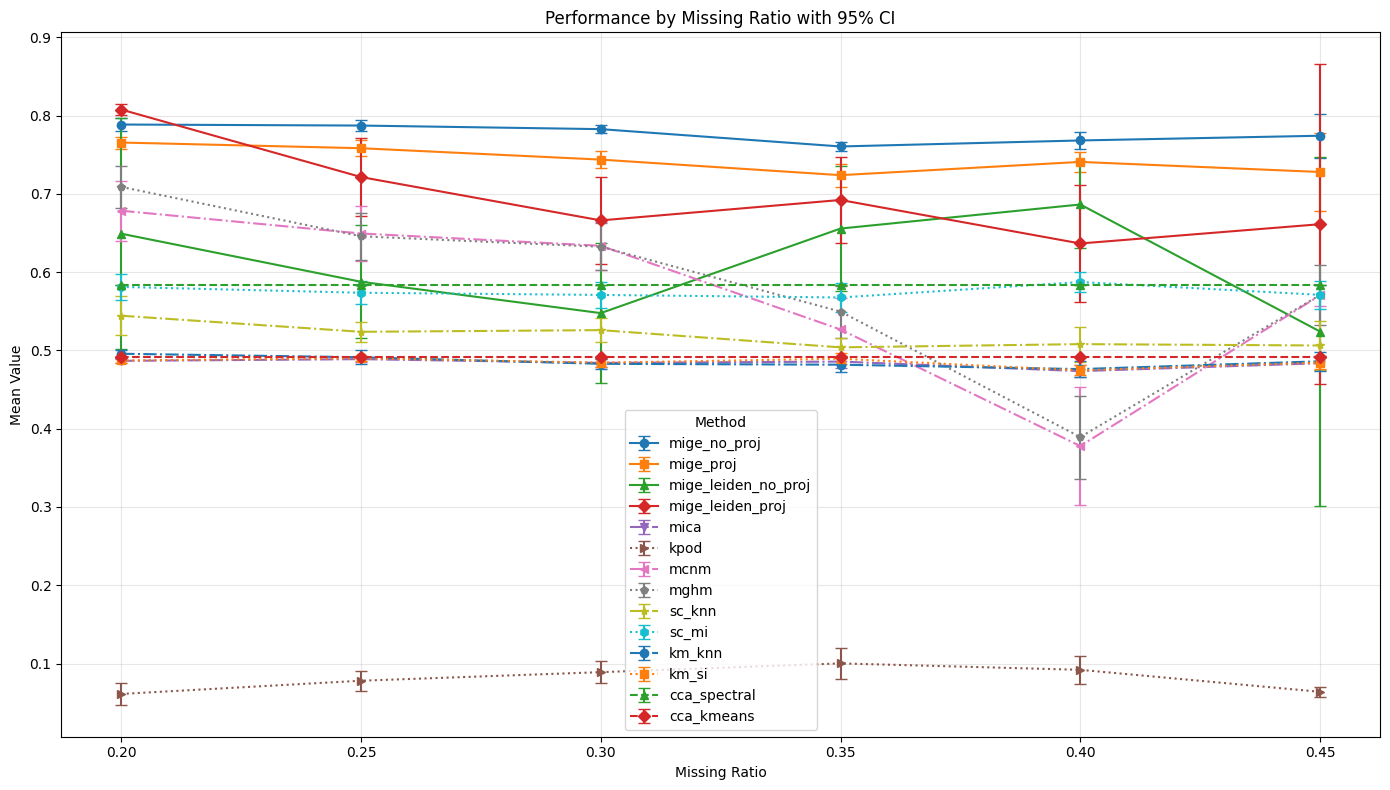

In [104]:
# Example data
data = external_metrics_binned[17]['ari']

plt.figure(figsize=(14, 8))



for method, ratios in data.items():
    x = []
    y = []
    yerr = []
    
    for missing_ratio, values in sorted(ratios.items()):
        mean = np.mean(values)
        sem = stats.sem(values)  # Standard error of the mean
        ci95 = sem * stats.t.ppf(0.975, len(values)-1)  # 95% CI
        
        x.append(missing_ratio)
        y.append(mean)
        yerr.append(ci95)
    
    plt.errorbar(
        x, 
        y, 
        yerr=yerr,
        marker=style[method]['marker'],
        linestyle=style[method]['linestyle'],
        capsize=4, 
        label=method
        )

plt.xlabel("Missing Ratio")
plt.ylabel("Mean Value")
plt.title("Performance by Missing Ratio with 95% CI")
plt.legend(title="Method")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()